# IMDB Film Yorumları ile Duygu Analizi
Bu projede IMDB film yorumları veriseti kullanılarak derin öğrenme tabanlı bir duygu analiz sistemi geliştirilecektir.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import classification_report


## Veri Seti İndirme ve Dosya Yapısının İncelenmesi

In [17]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!ls aclImdb
!mkdir aclImdb/train_cleaned
!cp -r aclImdb/train/pos aclImdb/train_cleaned/
!cp -r aclImdb/train/neg aclImdb/train_cleaned/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5468k      0  0:00:15  0:00:15 --:--:-- 8133k
imdbEr.txt  imdb.vocab	README	test  train


## Veri Yükleme ve Ön İşleme

In [18]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train_cleaned",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train_cleaned",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


## Metin Temizleme ve Vektörleştirme

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

def custom_standardization(text):
    lowercase = tf.strings.lower(text)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    cleaned_text = tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")
    return cleaned_text

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length)

# Vektörleştirme katmanını eğit
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.map(vectorize_text).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.map(vectorize_text).cache().prefetch(buffer_size=AUTOTUNE)


## Modelin Kurulması

In [21]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, input_shape=(sequence_length,)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])



In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## Modelin Eğitilmesi

In [23]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 250ms/step - accuracy: 0.5761 - loss: 0.6375 - val_accuracy: 0.7254 - val_loss: 0.4919
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 244ms/step - accuracy: 0.8441 - loss: 0.3713 - val_accuracy: 0.7648 - val_loss: 0.4389
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 238ms/step - accuracy: 0.8984 - loss: 0.2658 - val_accuracy: 0.7938 - val_loss: 0.4700
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 244ms/step - accuracy: 0.9143 - loss: 0.2265 - val_accuracy: 0.7540 - val_loss: 0.6538
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.9219 - loss: 0.2172 - val_accuracy: 0.8178 - val_loss: 0.4129
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.9398 - loss: 0.1712 - val_accuracy: 0.8440 - val_loss: 0.4482
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.9482 - loss: 0.1498 - val_accuracy: 0.8498 - val_loss: 0.5040
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 242ms/step - accuracy: 0.9584 -

## Eğitim Sonuçlarının Görselleştirilmesi

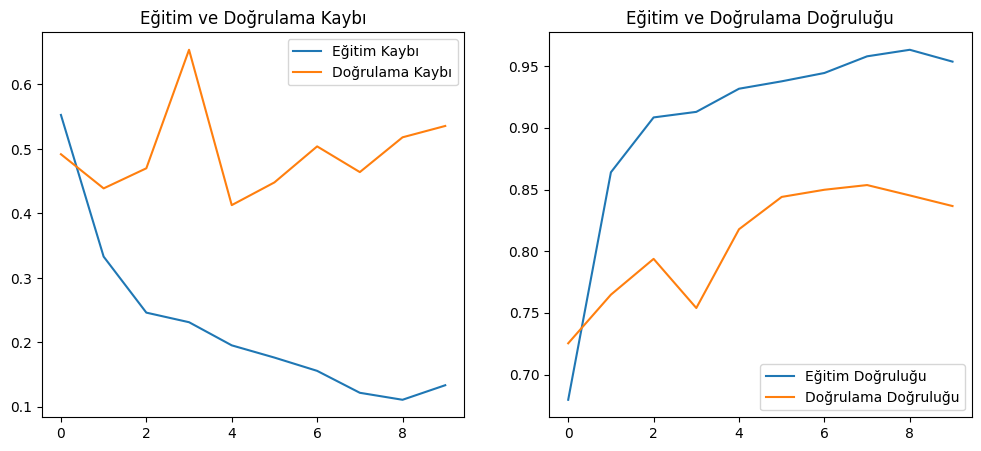

In [24]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.show()


## Modelin Test Verisi Üzerindeki Performansı

In [25]:
results = model.evaluate(test_ds)
print(f"Test Doğruluğu: {results[1]*100:.2f}%")


782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.8200 - loss: 0.5945
Test Doğruluğu: 81.71%


In [26]:


class_names = raw_train_ds.class_names  # ['neg', 'pos']

for text_batch, label_batch in raw_test_ds.take(1):
    sample_texts = text_batch[:20]
    sample_labels = label_batch[:20]

    # Vektörleştir
    vectorized_texts = vectorize_layer(sample_texts)

    # Tahmin yap
    predictions = model.predict(vectorized_texts)
    predictions = tf.squeeze(predictions).numpy()

    for i in range(20):
        print(f"Yorum {i+1}:")
        print(sample_texts[i].numpy().decode('utf-8')[:300], "...")
        print(f"Gerçek Etiket: {class_names[sample_labels[i]]}")
        print(f"Tahmin (Pozitif olasılığı): {predictions[i]:.2f}")
        print(f"Tahmin Etiketi: {'pos' if predictions[i] >= 0.5 else 'neg'}")
        print("-" * 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
Yorum 1:
This is a family movie that was broadcast on my local ITV station at 1.00 am a couple of nights ago . This might be a strange decision on the part of the schedulers but THE REAL HOWARD SPITZ is a rather strange film , strange in the way it doesn't want to upset its audience . Come on there's nothing ...
Gerçek Etiket: neg
Tahmin (Pozitif olasılığı): -2.13
Tahmin Etiketi: neg
--------------------------------------------------------------------------------
Yorum 2:
Whatever you do, don't stop watching when you think the movie is over! Hang around for the first batch of credits or you'll really miss something! We saw this movie at the Savanaah film festival and thought it was the best of the bunch. Dreya Weber is a marvel really, not only because of her perform ...
Gerçek Etiket: pos
Tahmin (Pozitif olasılığı): 0.62
Tahmin Etiketi: pos
--------------------------------------------------------------------------------
Yorum 3:
I saw this fine f

## Sonuç
Model, IMDB yorumları üzerinde başarılı bir şekilde duygu analizi yapmaktadır. Daha gelişmiş modeller ve gömülü kelime temsilleriyle performans daha da artırılabilir.